In [1084]:
import math, os
import pydicom
import numpy as np
import pandas as pd
from utils import display
from scipy import ndimage
import matplotlib.pyplot as plt

- crop edge out : some wrong value
- find MTF bar

In [1085]:
# by col
def find_edge_col(arr) :
    # Return width min to max
    nrows, ncols = arr.shape
    none_count = 0
    appended = False
    none_ts = 10
    start_none_count = 0
    start_val = arr[int(nrows*.2)][int(ncols*.2)]
    edges_pos = []
    for c in range(ncols) :
        is_c = None
        for r in range(nrows) :
            val = arr[r][c]
            if val != start_val :
                edges_pos.append(c)
                is_c = True
                appended = True # append number already
                none_count = 0
                break
        if not is_c :
            none_count += 1
            start_none_count += 1
            edges_pos.append(0) 
            if none_count >= none_ts and appended :
                break
    w_min, w_max = edges_pos[start_none_count+1-none_ts], edges_pos[-none_ts-1]
    # check is correct
    if w_max-w_min < int(0.15*ncols) :
        w_crop = w_max-w_min+5 # prevent it's equalt = 0
        w_min, w_max = find_edge_col(arr[:, w_crop:])
        w_min, w_max = w_min + w_crop, w_max + w_crop
    return w_min, w_max

In [1086]:
# by row
def find_edge_row(arr) :
    # Return width min to max
    nrows, ncols = arr.shape
    none_count = 0
    appended = False
    none_ts = 10
    start_none_count = 0
    start_val = arr[int(nrows*.2)][int(ncols*.2)]
    edges_pos = []
    for r in range(nrows) :
        is_r = None
        for c in range(ncols) :
            val = arr[r][c]
            if val != start_val :
                edges_pos.append(r)
                is_r = True
                appended = True # append number already
                none_count = 0
                break
        if not is_r :
            none_count += 1
            start_none_count += 1
            edges_pos.append(0) 
            if none_count >= none_ts and appended :
                break
    h_min, h_max = edges_pos[start_none_count+1-none_ts], edges_pos[-none_ts-1]
    # check is correct
    if h_max-h_min < int(0.15*nrows) :
        h_crop = h_max-h_min+5 # prevent it's equalt = 0
        h_min, h_max, start_val = find_edge_row(arr[h_crop:, :])
        h_min, h_max = h_min + h_crop, h_max + h_crop
    return h_min, h_max, start_val

In [1087]:
# dicom_data = pydicom.dcmread("images/DICOMOBJ/BAR2")
dicom_data = pydicom.dcmread("MTF_TEST\MTF_BAR (39)")
arr = dicom_data.pixel_array
h, w = arr.shape
# assume crop if size > 2,000 (not crop yet)
p = 0.24
if (h*w) > (2000**2) :
    arr = arr[int(h*p): int(h*(1-p)), int(w*p): int(w*(1-p))]

ecrop = [int(0.05*h), int(0.95*h), int(0.05*w), int(0.95*w)]
arr = arr[ecrop[0]: ecrop[1], ecrop[2]: ecrop[3]]
h, w = arr.shape
# find MTF bar
p = 0.33
p_mean = np.mean(arr[int(h*p): int(h*(1-p)), int(w*p): int(w*(1-p))])
parr = np.where(arr>p_mean, 1, 0)
# width finding
vc = [int(h*0.1), int(h/2)]
varr = parr[vc[0]: vc[1]]
w_min, w_max = find_edge_col(varr)
# height finding
hc = [int(w*0.1), int(w/2)]
harr = parr[:, hc[0]: hc[1]]
h_min, h_max, start_val = find_edge_row(harr)
# processing crop, inv, rotate to horizontal
need_inv = start_val == 1
l1, l2 = h_max-h_min, w_max-w_min
need_rotate = l1 > l2 
add_crop = int(0.1*l1) if l1>l2 else int(0.1*l2)
h_min, h_max = max(0, h_min-add_crop), h_max+add_crop # prevent negative 
w_min, w_max = max(0, w_min-add_crop), w_max+add_crop
arr = arr[h_min: h_max, w_min: w_max]
h, w = arr.shape
if need_inv :
    max_val = arr.max()
    arr = max_val-arr
if need_rotate :
    arr = ndimage.rotate(arr, 90)
    h, w = arr.shape
    print("RO")

In [1088]:
arr.shape, need_inv

((442, 941), False)

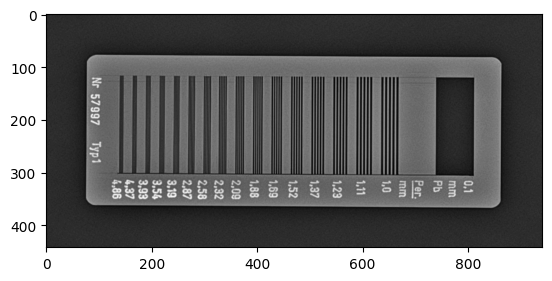

In [1089]:
# arr = ndimage.rotate(arr, 180)
display(arr, True)

In [1090]:
h, w

(442, 941)

In [1091]:
hp = int(0.28*h)
wp = int(0.03*w)

### FOCUS

In [1092]:
focus_l = arr[h-2*hp: int(h*.95), wp*9: wp*11]
nrows, ncols = focus_l.shape
nrows, ncols

(223, 56)

In [1093]:
def argdiffs(arr) :
    """ 
    find most differents position of pixel value by col
    Return: argdiff in len(col)
    """
    nrows, ncols = arr.shape
    arg_diffs = []
    for c in range(ncols) :
        max_diff = 0
        argmax_diff = 0
        for r in range(nrows) :
            # find different of past val 
            if r+1 < nrows : # index out of length
                cur_val = arr[r][c]
                next_val = arr[r+1][c]
                diff = abs(int(cur_val) - int(next_val)) # overflow
                if diff > max_diff :
                    max_diff = diff
                    argmax_diff = r
        arg_diffs.append(argmax_diff)
    return arg_diffs

In [1094]:
arg_diffs = argdiffs(focus_l)
len(arg_diffs)

56

In [1095]:
unique_elements, counts = np.unique(arg_diffs, return_counts=True)
unique_elements, counts

(array([127, 132, 133, 135, 143, 145, 146, 147, 148, 150, 151, 152, 154,
        166, 167]),
 array([ 1,  1,  1,  1,  4,  2,  4,  1,  4,  1,  1,  2,  5, 12, 16],
       dtype=int64))

In [1096]:
# most common argdiff
arg_diffs = argdiffs(focus_l)
unique_elements, counts = np.unique(arg_diffs, return_counts=True)
most_common_index = np.argmax(counts)
y1 = unique_elements[most_common_index]
y1

167

In [1097]:
focus_r = arr[h-2*hp: int(h*.95), w-(wp*11): w-(wp*9)]
nrows, ncols = focus_r.shape
nrows, ncols

(223, 56)

In [1098]:
# most common argdiff
arg_diffs = argdiffs(focus_r)
unique_elements, counts = np.unique(arg_diffs, return_counts=True)
most_common_index = np.argmax(counts)
y2 = unique_elements[most_common_index]
y2

169

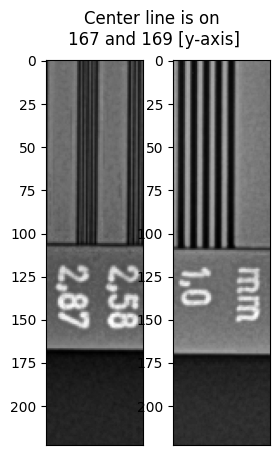

In [1099]:
plt.figure(figsize=(3, 5))
plt.subplot(1, 2, 1)
display(focus_l, axis=True)
plt.tick_params(bottom=False, labelbottom=False) # hide x-axis

plt.subplot(1, 2, 2)
display(focus_r, axis=True)
plt.tick_params(bottom=False, labelbottom=False)
plt.suptitle(f"Center line is on \n{y1} and {y2} [y-axis]");

In [1100]:
def find_theta(w, y1, y2) :
    """
    find theta from y1, y2
    Return: theta in degree
    """
    a = y2-y1
    theta_r = math.atan(a/w)
    print(theta_r)
    theta_d = math.degrees(theta_r)
    return theta_d

In [1101]:
y2, y1

(169, 167)

In [1102]:
theta = find_theta(w, y1, y2)
theta

0.002125395311862138


0.1217761811665919

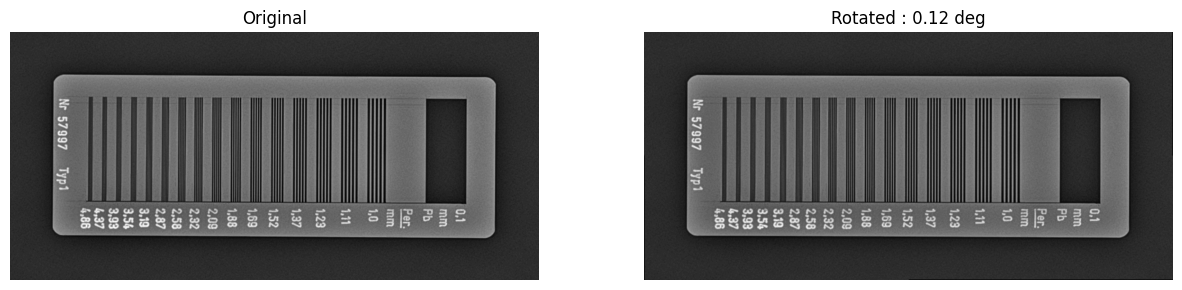

In [1103]:
if theta > 3 :
    # wrong direction
    arr = ndimage.rotate(arr, 180)

rotate_img = ndimage.rotate(arr, theta, reshape=False, cval=arr.min())

plt.figure(figsize=(15, 7))
plt.subplot(1, 2, 1)
plt.title("Original")
display(arr)

plt.subplot(1, 2, 2)
plt.title(f"Rotated : {theta:.2f} deg")
display(rotate_img)

In [1104]:
h, w = rotate_img.shape
h, w

(442, 941)

In [1105]:
hp = int(0.11*h)
wp = int(0.10*w)

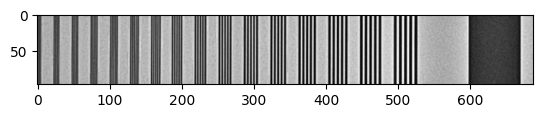

In [1106]:
focus_crop = (h//2-hp, h//2+hp, int(wp*1.5), w-int(wp*1.2))
focus = rotate_img[h//2-hp: h//2+hp, int(wp*1.5): w-int(wp*1.2)]
display(focus, True)

In [1107]:
focus.shape

(96, 688)

1589.5709495249462


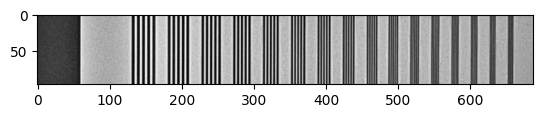

In [1108]:
rotate_check = focus[:, :int(wp/3)]
std = np.std(rotate_check)
print(std)
if std > (focus.max() - focus.min())/30 :
    rotate_img = ndimage.rotate(rotate_img, 180)
    focus = rotate_img[h//2-hp: h//2+hp, int(wp*1.5): w-int(wp*1.2)]
    display(focus, True)

In [1109]:
focus.shape

(96, 688)

442 941


(173, 269, 141, 829)

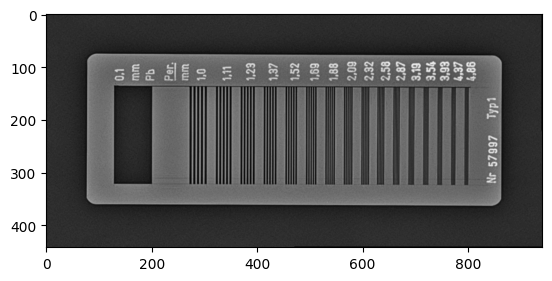

In [1110]:
print(h, w)
display(rotate_img, True)
focus_crop

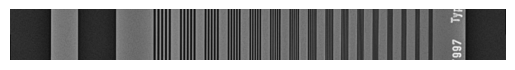

In [1111]:
display(rotate_img[focus_crop[0]: focus_crop[1], :])

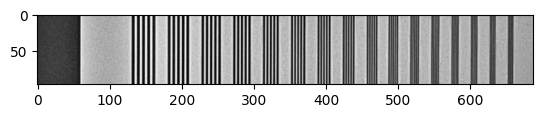

In [1112]:
display(rotate_img[focus_crop[0]: focus_crop[1], focus_crop[2]: focus_crop[3]], True)

In [1113]:
# mean by col
oneline_ori = np.mean(focus, axis=0, dtype=np.uint32)
p_mean = np.mean(oneline_ori)
oneline = np.where(oneline_ori > p_mean, 1, 0)
s = np.vstack((oneline, oneline, oneline, oneline, oneline, oneline, oneline, oneline, oneline))
display(s)

In [1114]:
space_ts = int(0.02*len(oneline))
positions = []
is_start = True
start_val = None
none_count = 0 # for not lp
for idx, val in enumerate(oneline) :
    if idx+1 == len(oneline) and len(positions) != 17 : # forgot last one
            positions.append((start_val, idx-space_ts))
    # just first lp
    if len(positions) == 0 :
        if val == 1 :
            positions.append((0, idx))
    else :
        if is_start :
            if val == 0 :
                is_start = False
                start_val = idx
        else :
            if val == 1 :
                none_count += 1
                if none_count > space_ts :
                    positions.append((start_val, idx-space_ts)) # back to correct point
                    is_start = True
                    none_count = 0
            else :
                none_count = 0

In [1115]:
positions, len(positions)

([(0, 60),
  (131, 164),
  (181, 211),
  (228, 255),
  (272, 297),
  (313, 335),
  (352, 372),
  (389, 407),
  (424, 441),
  (457, 472),
  (487, 501),
  (518, 530),
  (547, 558),
  (575, 585),
  (602, 611),
  (628, 636),
  (653, 661)],
 17)

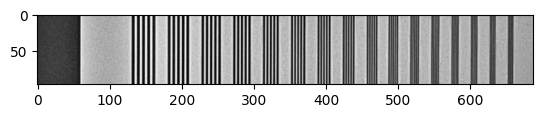

In [1116]:
plt.subplot(2, 1, 1)
display(focus, True)

In [1117]:
focus.shape 

(96, 688)

In [1118]:
focus_crop

(173, 269, 141, 829)

In [1119]:
focus_crop

(173, 269, 141, 829)

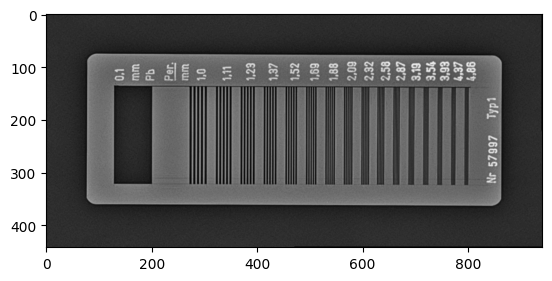

In [1120]:
display(rotate_img, True)

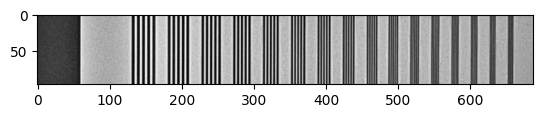

In [1121]:
display(rotate_img[focus_crop[0]: focus_crop[1], focus_crop[2]: focus_crop[3]], True)

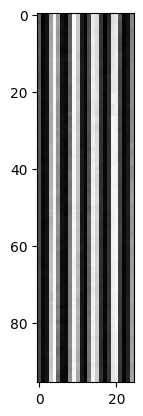

In [1122]:
lp = 4
display(focus[:, positions[lp][0]: positions[lp][1]], True)

In [1123]:
linepairs = []
for idx in range(len(positions)) :
    if idx < 9 :
        trim = int(0.0028*len(oneline))
    else :
        trim = int(0.004*len(oneline))
    s1, s2 = positions[idx][0]+trim, positions[idx][1]-trim
    if s2 > s1 : 
        linepairs.append((s1, s2))
    else :
        linepairs.append((s1+1, s1+2))

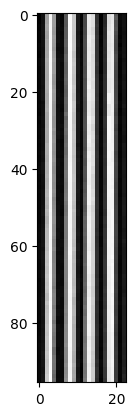

In [1124]:
linepair_idx = 4
display(focus[:, linepairs[linepair_idx][0]: linepairs[linepair_idx][1]], True)

In [1125]:
focus.shape, linepairs, oneline_ori.shape, arr.shape

((96, 688),
 [(1, 59),
  (132, 163),
  (182, 210),
  (229, 254),
  (273, 296),
  (314, 334),
  (353, 371),
  (390, 406),
  (425, 440),
  (459, 470),
  (489, 499),
  (520, 528),
  (549, 556),
  (577, 583),
  (604, 609),
  (630, 634),
  (655, 659)],
 (688,),
 (442, 941))

In [1126]:
min_val0 = int(np.min(oneline_ori[linepairs[0][0]: linepairs[0][1]]))
max_val0 = int(np.max(oneline_ori[linepairs[0][1]: linepairs[1][0]]))
max_contrast = max_val0 - min_val0
min_val0, max_val0, max_contrast

(4010, 10593, 6583)

In [1127]:
# s1, s2 = linepairs[0][0], linepairs[0][1]
# mean_val_col = oneline_ori[s1: s2]
# sorted_val = np.sort(mean_val_col) # to seperate max and min vals
# mid_pos = max(min((s2-s1)//2, int(0.21*(s2-s1))), 1) # how to select actual value, 1 if 0
# # mean_min_vals = round(np.mean(sorted_val[: mid_pos]))
# # mean_max_vals = round(np.mean(sorted_val[-mid_pos: ]))
# min_val0 = round(np.mean(sorted_val[: mid_pos]))
# max_val0 = round(np.mean(sorted_val[-mid_pos: ]))

# max_contrast = max_val0 - min_val0
# min_val0, max_val0, max_contrast

In [1128]:
linepairs

[(1, 59),
 (132, 163),
 (182, 210),
 (229, 254),
 (273, 296),
 (314, 334),
 (353, 371),
 (390, 406),
 (425, 440),
 (459, 470),
 (489, 499),
 (520, 528),
 (549, 556),
 (577, 583),
 (604, 609),
 (630, 634),
 (655, 659)]

In [1129]:
res = {"Linepair": [0], "Max": [max_val0], "Min": [min_val0], "Contrast": [max_contrast], "Modulation": [100]}
for idx, (s1, s2) in enumerate(linepairs[1:], start=1) :
    # in case of MTF bar (hardware error)
    if idx == 13 :
        continue     
    # if idx == 15 : # change bar 13
    #     new_max = (res["Max"][12] + res["Max"][14])//2
    #     new_min = (res["Min"][12] + res["Min"][14])//2
    #     new_contrast = new_max - new_min
    #     new_modulation = round(new_contrast*100/max_contrast, 3)
    #     res["Max"][13] = new_max
    #     res["Min"][13] = new_min
    #     res["Contrast"][13] = new_contrast
    #     res["Modulation"][13] = new_modulation

    # linepair = focus[:, s1: s2]
    # mean_val_col = np.mean(linepair, axis=0)
    mean_val_col = oneline_ori[s1: s2]
    sorted_val = np.sort(mean_val_col) # to seperate max and min vals
    if idx < 7 :
        w = 0.21
    else :
        w = 0.35
    mid_pos = max(min((s2-s1)//2, int(w*(s2-s1))), 1) # how to select actual value, 1 if 0
    # mean_min_vals = round(np.mean(sorted_val[: mid_pos]))
    # mean_max_vals = round(np.mean(sorted_val[-mid_pos: ]))
    min_vals = round(np.mean(sorted_val[: mid_pos]))
    max_vals = round(np.mean(sorted_val[-mid_pos: ]))
    # min_vals = np.min(mean_min_vals)
    # max_vals = np.max(mean_max_vals)
    # min_vals = np.min(mean_val_col)
    # max_vals = np.max(mean_val_col)
    contrast = max_vals-min_vals
    res["Linepair"].append(idx)
    res["Max"].append(max_vals)
    res["Min"].append(min_vals)
    res["Contrast"].append(contrast)
    res["Modulation"].append(round(contrast*100/max_contrast, 3))
res = pd.DataFrame(res)

In [1130]:
# plt.figure(figsize=(10, 6))
# plt.plot(oneline_ori, color="black", linewidth=1)
# for idx, ((s1, s2), (_, max_v, min_v, _, _)) in enumerate(zip(linepairs, res.values), start=1) :
#     plt.plot([s1, s2], [max_v, max_v], color="red")
#     plt.plot([s1, s2], [min_v, min_v], color="blue")
# plt.legend(["value", "0.2(7)0.3avg-skip", "0.2(7)0.3avg-skip"])
# plt.grid(True)
# plt.title("Linepairs pixel values")
# plt.ylabel("Pixel value")
# plt.xlabel("Position");

In [1131]:
e1, e2 = linepairs[12][1], linepairs[13][0]
e3, e4 = linepairs[13][1], linepairs[14][0]
sk1, sk2 = int((e1+e2)/2), int((e3+e4)/2)
x = oneline_ori.tolist()[: sk1] + oneline_ori.tolist()[sk2 :]

In [1132]:
# plt.figure(figsize=(10, 6))
# start_val = linepairs[0][0] - (linepairs[0][1] - linepairs[0][0])
# plt.plot(x[start_val :], color="black", linewidth=1)
# for idx, ((s1, s2), (_, max_v, min_v, _, _)) in enumerate(zip(linepairs, res.values), start=1) :
#     plt.plot([s1-start_val, s2-start_val], [max_v, max_v], color="red")
#     plt.plot([s1-start_val, s2-start_val], [min_v, min_v], color="blue")
# plt.legend(["value", "0.2(7)0.3avg-skip", "0.2(7)0.3avg-skip"])
# plt.grid(True)
# plt.title("Linepairs pixel values")
# plt.ylabel("Pixel value")
# plt.xlabel("Position");

In [1133]:
focus_crop

(173, 269, 141, 829)

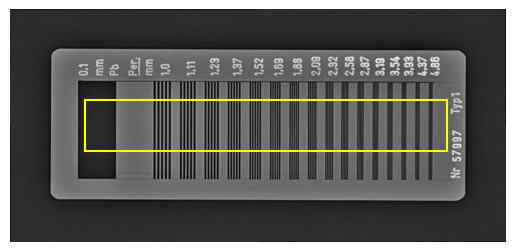

In [1134]:
display(rotate_img)
# [x1, x2] [y1, y2]
plt.plot([focus_crop[2], focus_crop[2]], [focus_crop[0], focus_crop[1]], c='yellow') # left
plt.plot([focus_crop[3], focus_crop[3]], [focus_crop[0], focus_crop[1]], c='yellow') # right
plt.plot([focus_crop[2], focus_crop[3]], [focus_crop[0], focus_crop[0]], c='yellow') # top
plt.plot([focus_crop[2], focus_crop[3]], [focus_crop[1], focus_crop[1]], c='yellow') # bottom

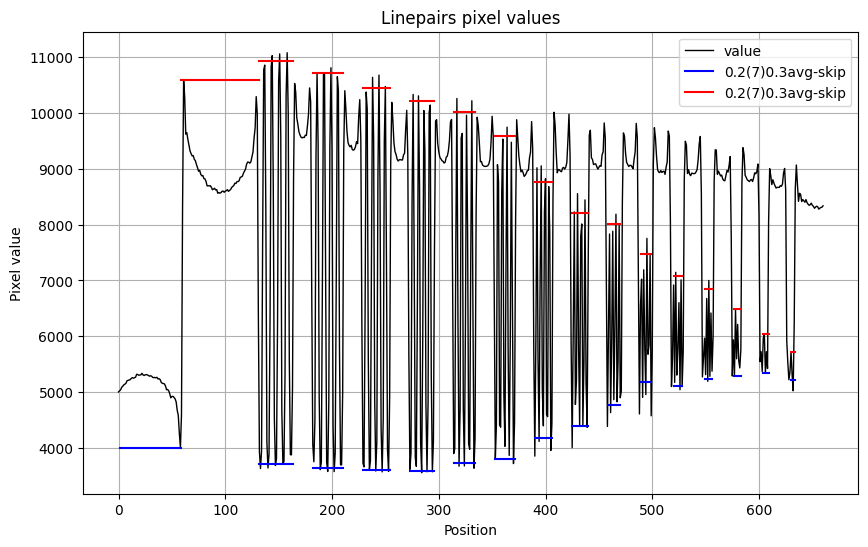

In [1135]:
plt.figure(figsize=(10, 6))
start_val = linepairs[0][0] - (linepairs[0][1] - linepairs[0][0])
plt.plot(x, color="black", linewidth=1)
for idx, ((s1, s2), (_, max_v, min_v, _, _)) in enumerate(zip(linepairs, res.values), start=1) :
    # fix position in first lp (maximum)
    plt.plot([s1, s2], [min_v, min_v], color="blue")
    if idx == 1 :
        s1 = s2
        s2 = linepairs[1][0]
    plt.plot([s1, s2], [max_v, max_v], color="red")
plt.legend(["value", "0.2(7)0.3avg-skip", "0.2(7)0.3avg-skip"])
plt.grid(True)
plt.title("Linepairs pixel values")
plt.ylabel("Pixel value")
plt.xlabel("Position");

In [1136]:
res

,Linepair,Max,Min,Contrast,Modulation
0,0,10593,4010,6583,100.000
1,1,10929,3711,7218,109.646
2,2,10706,3637,7069,107.383
3,3,10440,3605,6835,103.828
4,4,10200,3584,6616,100.501
5,5,10012,3726,6286,95.488
6,6,9580,3799,5781,87.817
7,7,8757,4180,4577,69.528
8,8,8204,4393,3811,57.892
9,9,8015,4777,3238,49.187


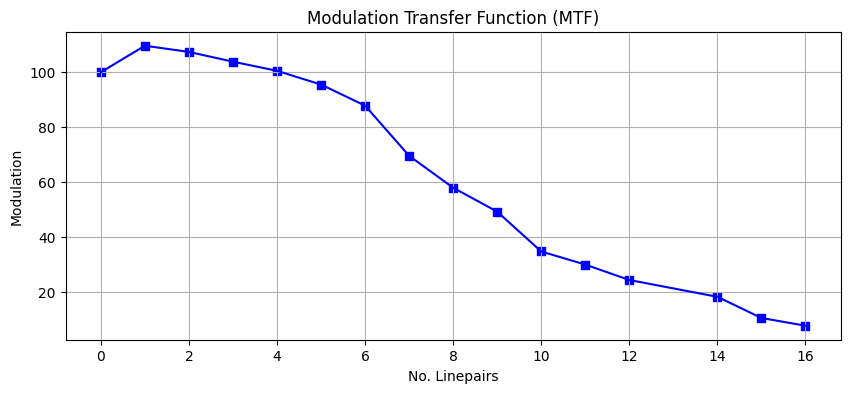

In [1137]:
plt.figure(figsize=(10, 4))
plt.title("Modulation Transfer Function (MTF)")
plt.plot(res["Linepair"], res["Modulation"], color="blue")
plt.scatter(res["Linepair"], res["Modulation"], color="blue", marker="s")
plt.grid(True)
plt.ylabel("Modulation")
plt.xlabel("No. Linepairs");